# Create an index to the harvested files

The XML files contain embedded metadata that includes the name of the prime minister, and the title and date of the transcript. This notebook extracts that metadata from the harvested files and creates a CSV formatted spreadsheet for easy analysis. It also demonstrates some ways of summarising and visualising the metadata.

In [113]:
import os
from bs4 import BeautifulSoup
import arrow
import pandas as pd
import altair as alt

# Set up Altair
#alt.renderers.enable('notebook')
alt.renderers.enable('default')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Extract the metadata as save as a CSV

In [114]:
def get_tag(soup, tag):
    '''
    Given some Soup, find the specified tag and return its value.
    '''
    try:
        value = soup.find(tag).string.strip()
    except AttributeError:
        value = ''
    return value

# Create a list to put the metadata in
all_details = []

# Get the file names of all the harvested files
files = [f for f in os.listdir('transcripts') if f[-4:] == '.xml']

# Loop through the harvested files
for filename in files:
    
    # Open the file
    with open(os.path.join('transcripts', filename), 'rb') as xml_file:
        
        # Create a dict to put this file's metadata in
        details = {}
        
        # Load the file contents into Soup and then get the desired tags
        soup = BeautifulSoup(xml_file.read())
        details['id'] = get_tag(soup, 'transcript-id')
        details['title'] = get_tag(soup, 'title')
        details['pm'] = get_tag(soup, 'prime-minister')
        
        # We're going to reformat the date into the ISO standard, so first get the value
        release_date = get_tag(soup, 'release-date')
        try:
            # Then try to parse the date and reformat as ISO
            iso_date = arrow.get(release_date, 'DD/MM/YYYY').format('YYYY-MM-DD')
        except:
            # If something goes wrong...
            iso_date = ''
        details['date'] = iso_date
        details['release_type'] = get_tag(soup, 'release-type')
        details['subjects'] = get_tag(soup, 'subjects')
        details['pdf'] = get_tag(soup, 'document')
        
        # Add the metadata for this file to the list
        all_details.append(details)
        

In [115]:
# Convert the metadata to a Pandas dataframe
df = pd.DataFrame(all_details)
df.head()

,date,id,pdf,pm,release_type,subjects,title
0,2014-08-24,23765,,"Abbott, Tony",Media Release,,A message from the Prime Minister - Building a...
1,1968-03-14,1797,https://pmtranscripts.pmc.gov.au/sites/default...,"Gorton, John",Statement in Parliament,,STATEMENT BY THE PRIME MINISTER THE RT.HON. JO...
2,2016-11-17,40598,,"Turnbull, Malcolm",Transcript,,Press Conference at the launch of the Veterans...
3,1978-09-27,4837,https://pmtranscripts.pmc.gov.au/sites/default...,"Fraser, Malcolm",Media Release,,GRANT TO WORLD WILDLIFE FUND AUSTRALIA
4,2004-03-24,21172,,"Howard, John",Interview,,"Doorstop Interview Great Hall, Parliament Hous..."


Save the index as a CSV formatted file.

In [116]:
# Save the metadata as a CSV file
df.to_csv('index.csv', index=False)

## Analyse the metadata

In [117]:
# This loads the metadata from the CSV
# This is not necessary if you've just generated the df
df = pd.read_csv('index.csv', keep_default_na=False)

Let's have a look at the number of transcripts for each Prime Minister.

In [118]:
df['pm'].value_counts()

Howard, John         5865
Hawke, Robert        2321
Fraser, Malcolm      2081
Gillard, Julia       2072
Turnbull, Malcolm    1751
Rudd, Kevin          1735
Keating, Paul        1582
Abbott, Tony         1371
Whitlam, Gough       1238
Menzies, Robert      1212
Gorton, John          625
Holt, Harold          507
McMahon, William      349
                       74
McEwen, John           16
Chifley, Ben           11
Curtin, John            4
Name: pm, dtype: int64

Note that there are 73 transcripts that have no Prime Minister associated with them. We'll exclude those and chart the rest.

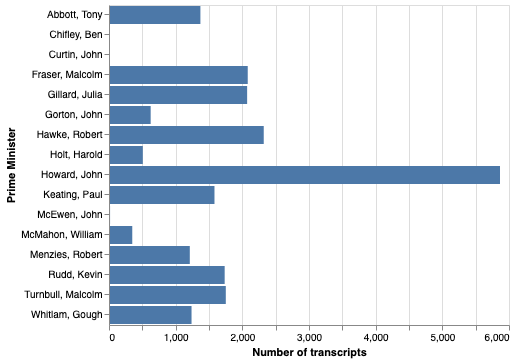

In [112]:
# We're exlusing those transcripts where the 'pm' value is empty - df.loc[df['pm'] != '']
alt.Chart(df.loc[df['pm'] != '']).mark_bar().encode(
    
    # Show number of transcripts on X axis
    x=alt.X('count():Q', title='Number of transcripts'),
    
    # Show the name of the PM on the Y axis
    y=alt.Y('pm:N', title='Prime Minister'),
    
    # Show details when you hover
    tooltip=[alt.Tooltip('pm:N', title='Prime Minister'), alt.Tooltip('count():Q', title='Transcripts')]
)

Let's have a look at the number of transcripts over time.

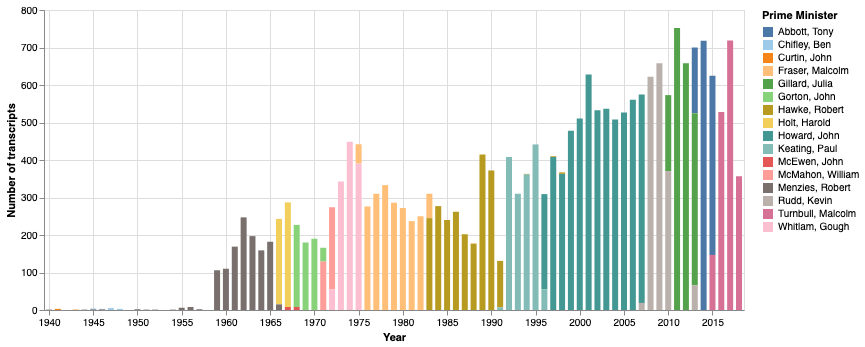

In [119]:
alt.Chart(df.loc[df['pm'] != '']).mark_bar(size=6).encode(
    
    # Year on the X axis
    x=alt.X('year(date):T', title='Year'),
    
    # Number of transcripts on the Y axis
    y=alt.Y('count():Q', title='Number of transcripts'),
    
    # Color denotes the PM (names will be in the legend)
    color=alt.Color('pm:N', scale=alt.Scale(scheme='tableau20'), legend=alt.Legend(title='Prime Minister')),
    
    # Show details on hover
    tooltip=[alt.Tooltip('pm:N', title='Prime Minister'), alt.Tooltip('year(date):T', title='Year'), alt.Tooltip('count():Q', title='Transcripts')]
).properties(width=700)

## Release types and subjects

The `release_type` field should tell us what sort of text this transcript represents – interview, media release, etc. Let's see how it's used.

In [96]:
df['release_type'].value_counts()

Media Release                            8686
Interview                                5352
Speech                                   4988
Transcript                               1746
Press Conference                          745
Statement in Parliament                   341
Video Transcript                          233
Correspondence                            131
Broadcast                                 111
                                           62
Message                                    54
Index                                      47
Statement                                  44
Doorstop                                   41
Government                                 36
Foreign Affairs                            16
Economy & Finance                          14
Education                                  14
Arts, Culture & Sport                      13
Environment                                12
Health                                     12
Communique                        

Hmmm, so it looks like there's not a lot of control over the values in this field – is a 'Press Statement' the same as a 'Media Release'? It also looks like some subjects have been incorrectly entered here.

By combining `groupby()` and `value_counts()` it's easy to look at the release types for each PM.

In [76]:
df.groupby('pm')['release_type'].value_counts()

pm                 release_type           
                   Interview                    39
                   Media Release                14
                   Speech                       13
                                                 5
                   Doorstop                      1
                   Press Conference              1
Abbott, Tony       Transcript                  620
                   Media Release               450
                   Speech                      245
                                                41
                   Remarks                       5
                   Interview                     2
                   Press Conference              2
                   Press Statement               2
                   Statement                     2
                   Doorstop                      1
                   Message                       1
Chifley, Ben       Speech                       11
Curtin, John       Speech              

Because the `release_type` field is a bit of a mess, let's get the top ten release types and visualise them for each PM.

In [94]:
# The index returned by value_counts() are the names of the release types, so we can convert to a list and slice off the first 10.
top_ten_types = df.loc[df['release_type'] != '']['release_type'].value_counts().index.to_list()[:10]

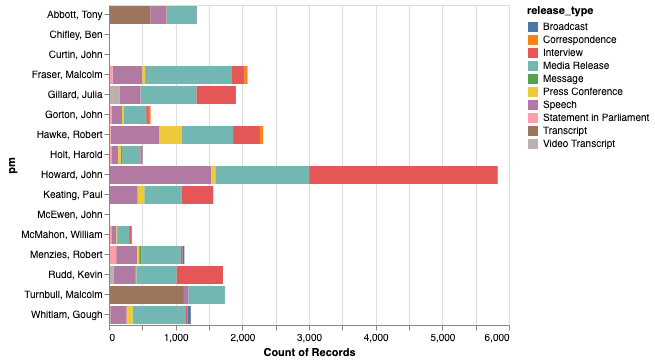

In [95]:
# We're exluding those transcripts where the 'pm' value is empty - df.loc[df['pm'] != '']
alt.Chart(df.loc[(df['pm'] != '') & (df['release_type'].isin(top_ten_types))]).mark_bar().encode(
    x='count():Q',
    y='pm:N',
    color='release_type:N'
)

In [99]:
df.loc[df['subjects'] != ''].shape

(1122, 7)

In [101]:
len(pd.unique(df['subjects']))

1036

In [98]:
df['subjects'].value_counts()

                                                                                                                                                                                                                                                                                                                21692
Same-sex marriage                                                                                                                                                                                                                                                                                                  14
Budget 2014.                                                                                                                                                                                                                                                                                                       14
East Timor                                                            